### Usage of PSOF in two layer distributed fusion

In S.-L. Sun and Z.-L. Deng, “Multi-sensor optimal information fusion kalman filter,” Automatica, vol. 40, no. 6, pp. 1017–1023, Jun. 2004. [Online]. Available: http://dx.doi.org/10.1016/j.automatica.2004.01.014, a two-layer fusion structure is proposed. The proposed structure requires computation of cross-correlations among distributed node, and hence require time sync and exchange of Kalman gain matrices. We propose to replace the second layer with PSOF-based data fusion algorithm to eliminate the need for time sync and further information exchange other than estimates and their covariances. In addition to the saved communication cost, the PSOF-based approach enhances system reliability and design flexibility.

### Comparative simulations

#### Methods based on Sun's paper

In [1]:
import math
import numpy as np

In [2]:
def local_kalman(x_t_t, p_t_t, y_tplus1, y_t, \
                 phi_t, gamma_t, h_tplus1, h_t, \
                 q_t, r_tplus1, r_t, s_t, b_t, u_t, \
                 w_t=np.zeros((1,1))):
    """
    Given previous estimates & current measurements
    to return updated estimates and Kalman gain
    Based on Kalman filtering formulation given in Sun's paper
    """
    i_n = np.identity(phi_t.shape[1])
    r_t_inv = np.linalg.inv(r_t)
    j_t = gamma_t @ s_t @ r_t_inv
    phi_t_bar = phi_t - j_t @ h_t
    x_tplus1_t = phi_t_bar @ x_t_t + b_t @ u_t + j_t @ y_t + gamma_t @ w_t
    epsilon_tplus1 = y_tplus1 - h_tplus1 @ x_tplus1_t
    p_tplus1_t = phi_t_bar @ p_t_t @ phi_t_bar.T + \
                 gamma_t @ (q_t - s_t @ r_t_inv @ s_t.T) @ gamma_t.T
    k_tplus1 = p_tplus1_t @ h_tplus1.T @ np.linalg.inv(h_tplus1 @ p_tplus1_t @ h_tplus1.T + r_tplus1)
    x_tplus1_tplus1 = x_tplus1_t + k_tplus1 @ epsilon_tplus1
    p_tplus1_tplus1 = (i_n - k_tplus1 @ h_tplus1) @ p_tplus1_t
    return x_tplus1_tplus1, p_tplus1_tplus1, k_tplus1

In [3]:
def compute_cross_covariance(phi_t, \
                         k_i_tplus1, k_i_t, k_j_tplus1, k_j_t, \
                         h_i_tplus1, h_i_t, h_j_tplus1, h_j_t, \
                         r_i_t, r_j_t, s_i_t, s_j_t, \
                         gamma_t, q_t, p_ij_t_t, s_ij_t, s_ij_tplus1):
    """
    Based on theorem 2 of Sun's paper
    """
    i_n = np.identity(phi_t.shape[1])

    r_i_t_inv = np.linalg.inv(r_i_t)
    j_i_t = gamma_t @ s_i_t @ r_i_t_inv
    phi_i_t_bar = phi_t - j_i_t @ h_i_t
    
    r_j_t_inv = np.linalg.inv(r_j_t)
    j_j_t = gamma_t @ s_j_t @ r_j_t_inv
    phi_j_t_bar = phi_t - j_j_t @ h_j_t
    
    return (i_n - k_i_tplus1 @ h_i_tplus1) @ \
           (phi_i_t_bar @ p_ij_t_t @ phi_j_t_bar.T + \
            gamma_t @ q_t @ gamma_t.T - j_j_t @ r_j_t @ j_j_t.T - \
            j_i_t @ r_i_t @ j_i_t.T + j_i_t @ s_ij_t @ j_j_t.T + \
            phi_i_t_bar @ k_i_t @ (s_ij_t @ j_j_t.T - s_i_t.T @ gamma_t.T) + \
            (j_i_t @ s_ij_t - gamma_t @ s_j_t) @ k_j_t.T @ phi_j_t_bar.T) @ \
           (i_n - k_j_tplus1 @ h_j_tplus1).T + \
           k_i_tplus1 @ s_ij_tplus1 @ k_j_tplus1.T

In [4]:
def optimal_fusion_known_cross_covariances(x_is, p_ijs):
    """
    Optimal fusion with known cross-covariances.
    Based on theorem 1 of Sun's paper
    """
    l = len(x_is)
    assert(len(p_ijs) == l * l)
    n = x_is[0].shape[0]
    assert(p_ijs[0].shape == (n, n))
    e = np.concatenate([np.identity(n) for _ in range(l)])
    Sigma = np.concatenate([np.concatenate(p_ijs[i*l:(i+1)*l], axis=1) for i in range(l)])
    # The Sigma matrix was observed to be often ill-conditioned,
    # hence we might need to add 1e-10 * I to correct
    Sigma_inv = np.linalg.inv(Sigma) # + 1e-10 * np.identity(n*l))
    P_0 = np.linalg.inv(e.T @ Sigma_inv @ e)
    A_bar = Sigma_inv @ e @ P_0
    x_0 = A_bar.T @ np.concatenate(x_is)
    return x_0, P_0

#### Parameter initializations based on Sun's paper

In [5]:
T = 0.01
gamma_tplus1 = gamma_t = np.array([[0.0, 0.0, 1.0]], dtype=float).T
phi_tplus1 = phi_t = np.array([[1.0, T, T * T / 2.0], [0.0, 1.0, T], [0.0, 0.0, 1.0]], dtype=float)
h_1_tplus1 = h_1_t = np.array([[1.0, 0.0, 0.0]], dtype=float)
h_2_tplus1 = h_2_t = np.array([[0.0, 1.0, 0.0]], dtype=float)
h_3_tplus1 = h_3_t = np.array([[0.0, 0.0, 1.0]], dtype=float)
h_tplus1 = h_t = np.concatenate((h_1_tplus1, h_2_tplus1, h_3_tplus1))
sigma_w_square = 1.0
sigma_zeta_1_square = 5.0
sigma_zeta_2_square = 8.0
sigma_zeta_3_square = 10.0
alpha_1 = 0.5
alpha_2 = 0.8
alpha_3 = 0.4
x_0 = np.full((3, 1), 0.0, dtype=float)
p_0 = 0.1 * np.identity(3)
s_1_tplus1 = s_1_t = np.full((1,1), alpha_1 * sigma_w_square, dtype=float)
s_2_tplus1 = s_2_t = np.full((1,1), alpha_2 * sigma_w_square, dtype=float)
s_3_tplus1 = s_3_t = np.full((1,1), alpha_3 * sigma_w_square, dtype=float)
s_21_tplus1 = s_21_t = s_12_tplus1 = s_12_t = np.full((1,1), alpha_1 * alpha_2 * sigma_w_square, dtype=float)
s_31_tplus1 = s_31_t = s_13_tplus1 = s_13_t = np.full((1,1), alpha_1 * alpha_3 * sigma_w_square, dtype=float)
s_32_tplus1 = s_32_t = s_23_tplus1 = s_23_t = np.full((1,1), alpha_2 * alpha_3 * sigma_w_square, dtype=float)
s_tplus1 = s_t = np.concatenate((s_1_t, s_2_t, s_3_t)).T

q_t = np.full((1,1), sigma_w_square, dtype=float)
r_1_tplus1 = r_1_t = np.full((1,1), sigma_zeta_1_square + alpha_1 * alpha_1 * sigma_w_square, dtype=float)
r_2_tplus1 = r_2_t = np.full((1,1), sigma_zeta_2_square + alpha_2 * alpha_2 * sigma_w_square, dtype=float)
r_3_tplus1 = r_3_t = np.full((1,1), sigma_zeta_3_square + alpha_3 * alpha_3 * sigma_w_square, dtype=float)
r_tplus1 = r_t = np.array([[r_1_t[0, 0], s_12_t[0, 0], s_13_t[0, 0]], \
                           [s_12_t[0, 0], r_2_t[0, 0], s_23_t[0, 0]], \
                           [s_13_t[0, 0], s_23_t[0, 0], r_3_t[0, 0]]], dtype=float)

y_tplus1 = y_t = np.zeros((3,1))
y_1_tplus1 = y_1_t = np.zeros((1,1))
y_2_tplus1 = y_2_t = np.zeros((1,1))
y_3_tplus1 = y_3_t = np.zeros((1,1))

b_t = b_3_t = b_2_t = b_1_t = np.zeros((3,1))
u_t = u_3_t = u_2_t = u_1_t = np.zeros((1,1))

iteration_count = 300

#### Reproducing some of the results in Sun's paper

##### Local Kalman filtering

In [6]:
local_kf_variances = []
x_3 = x_2 = x_1 = x_0
p_3 = p_2 = p_1 = p_0
local_kf_variances.append([p_1, p_2, p_3])
for _ in range(iteration_count):
    x_1, p_1, _ = local_kalman(x_1, p_1, y_1_tplus1, y_1_t, \
                            phi_t, gamma_t, h_1_tplus1, h_1_t, \
                            q_t, r_1_tplus1, r_1_t, s_1_t, b_1_t, u_1_t)
    x_2, p_2, _ = local_kalman(x_2, p_2, y_2_tplus1, y_2_t, \
                            phi_t, gamma_t, h_2_tplus1, h_2_t, \
                            q_t, r_2_tplus1, r_2_t, s_2_t, b_2_t, u_2_t)
    x_3, p_3, _ = local_kalman(x_3, p_3, y_3_tplus1, y_3_t, \
                            phi_t, gamma_t, h_3_tplus1, h_3_t, \
                            q_t, r_3_tplus1, r_3_t, s_3_t, b_3_t, u_3_t)
    local_kf_variances.append([p_1, p_2, p_3])

##### Centralized Kalman filtering

In [7]:
centralized_kf_variances = []
x_c = x_0
p_c = p_0
centralized_kf_variances.append(p_c)
for _ in range(iteration_count):
    x_c, p_c, _ = local_kalman(x_c, p_c, y_tplus1, y_t, \
                            phi_t, gamma_t, h_tplus1, h_t, \
                            q_t, r_tplus1, r_t, s_t, b_t, u_t)
    centralized_kf_variances.append(p_c)

##### Two-layer filtering in Sun's paper

In [8]:
two_layers_kf_variances = []
x_3 = x_2 = x_1 = x_0
p_21 = p_31 = p_32 = p_12 = p_13 = p_23 = p_0
p_3 = p_2 = p_1 = p_0
k_1_t = k_1_tplus1 = np.zeros((3,1))
k_2_t = k_2_tplus1 = np.zeros((3,1))
k_3_t = k_3_tplus1 = np.zeros((3,1))
two_layers_kf_variances.append(p_1)
for _ in range(iteration_count):
    k_1_t = k_1_tplus1
    k_2_t = k_2_tplus1
    k_3_t = k_3_tplus1
    x_1, p_1, k_1_tplus1 = local_kalman(x_1, p_1, y_1_tplus1, y_1_t, \
                            phi_t, gamma_t, h_1_tplus1, h_1_t, \
                            q_t, r_1_tplus1, r_1_t, s_1_t, b_1_t, u_1_t)
    x_2, p_2, k_2_tplus1 = local_kalman(x_2, p_2, y_2_tplus1, y_2_t, \
                            phi_t, gamma_t, h_2_tplus1, h_2_t, \
                            q_t, r_2_tplus1, r_2_t, s_2_t, b_2_t, u_2_t)
    x_3, p_3, k_3_tplus1 = local_kalman(x_3, p_3, y_3_tplus1, y_3_t, \
                            phi_t, gamma_t, h_3_tplus1, h_3_t, \
                            q_t, r_3_tplus1, r_3_t, s_3_t, b_3_t, u_3_t)
    p_12 = compute_cross_covariance(phi_t, \
                         k_1_tplus1, k_1_t, k_2_tplus1, k_2_t, \
                         h_1_tplus1, h_1_t, h_2_tplus1, h_2_t, \
                         r_1_t, r_2_t, s_1_t, s_2_t, \
                         gamma_t, q_t, p_12, s_12_t, s_12_tplus1)
    p_13 = compute_cross_covariance(phi_t, \
                         k_1_tplus1, k_1_t, k_3_tplus1, k_3_t, \
                         h_1_tplus1, h_1_t, h_3_tplus1, h_3_t, \
                         r_1_t, r_3_t, s_1_t, s_3_t, \
                         gamma_t, q_t, p_13, s_13_t, s_13_tplus1)
    p_23 = compute_cross_covariance(phi_t, \
                         k_2_tplus1, k_2_t, k_3_tplus1, k_3_t, \
                         h_2_tplus1, h_2_t, h_3_tplus1, h_3_t, \
                         r_2_t, r_3_t, s_2_t, s_3_t, \
                         gamma_t, q_t, p_23, s_23_t, s_23_tplus1)
    p_21 = p_12.T
    p_31 = p_13.T
    p_32 = p_23.T
    x_0_n, p_0_n = optimal_fusion_known_cross_covariances([x_1, x_2, x_3], \
                         [p_1, p_12, p_13, p_21, p_2, p_23, p_31, p_32, p_3])
    two_layers_kf_variances.append(p_0_n)

##### Distributed filtering assuming independence (Monte Carlo simulation)
1.   We first run the Monte Carlo simulation against Kalman filtering with node 1 alone to sanity check the simulation codes.
2.   Then we duplicate the codes to run the same simulation with the crudest assumption of independence.
3. In simulation, we assume the system state is fixed to be (0, 0, 0), i.e. no movement or acceleration. To simulate the initial state uncertainty, we use random initialization instead to achieve the goal of x_0 having covariance 0.1 I_3.

**Simulations for sanity check**

In [9]:
simulation_rounds = 300

w_t = np.random.normal(0.0, math.sqrt(sigma_w_square), \
                       (iteration_count, simulation_rounds))
zeta_1 = np.random.normal(0.0, math.sqrt(sigma_zeta_1_square), \
                       (iteration_count, simulation_rounds))
measure_noise_1 = alpha_1 * w_t + zeta_1

x_o_1 = np.zeros((3, iteration_count+1, simulation_rounds), dtype=float)

for r in range(simulation_rounds):
    y_1_tplus1 = 0.0
    p_1 = p_0
    init_std = math.sqrt(p_0[0, 0])
    x_1 = np.random.normal(0.0, init_std, (3,1))
    x_o_1[0, 0, r] = x_1[0,0]
    x_o_1[1, 0, r] = x_1[1,0]
    x_o_1[2, 0, r] = x_1[2,0]
    for i in range(iteration_count):
        y_1_t = y_1_tplus1
        y_1_tplus1 = measure_noise_1[i, r]
        x_1, p_1, _ = local_kalman(x_1, p_1, np.full((1,1), y_1_tplus1, dtype=float), \
                                np.full((1,1), y_1_t, dtype=float), \
                                phi_t, gamma_t, h_1_tplus1, h_1_t, \
                                q_t, r_1_tplus1, r_1_t, s_1_t, b_1_t, u_1_t, \
                                w_t=np.full((1,1), w_t[i,r], dtype=float))
        x_o_1[0, i+1, r] = x_1[0, 0]
        x_o_1[1, i+1, r] = x_1[1, 0]
        x_o_1[2, i+1, r] = x_1[2, 0]
x_o_1_vars = np.var(x_o_1, axis=2)

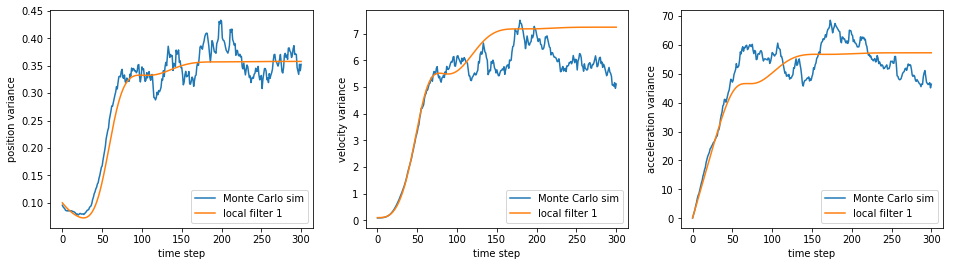

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(1, 3, figsize=(16, 4))

xlims = [(0, 100), (0, 300), (0, 10)]
ylims = [(0.0, 0.38), (0.07, 4), (1, 10)]
labels = ['position', 'velocity', 'acceleration']
for i in range(3):
    axes[i].set_xlabel('time step')
    axes[i].set_ylabel(f'{labels[i]} variance')
    axes[i].plot(x_o_1_vars[i,:], label="Monte Carlo sim")
    axes[i].plot([p[0][i,i] for p in local_kf_variances], label='local filter 1')
    axes[i].legend()

**Monte Carlo simulation for distributed filtering crudely assuming independence**

In [11]:
# Independence assumptions
p_21 = p_31 = p_32 = p_12 = p_13 = p_23 = np.zeros((3,3))

simulation_rounds = 300

w_t = np.random.normal(0.0, math.sqrt(sigma_w_square), \
                       (iteration_count, simulation_rounds))
zeta_1 = np.random.normal(0.0, math.sqrt(sigma_zeta_1_square), \
                       (iteration_count, simulation_rounds))
zeta_2 = np.random.normal(0.0, math.sqrt(sigma_zeta_2_square), \
                       (iteration_count, simulation_rounds))
zeta_3 = np.random.normal(0.0, math.sqrt(sigma_zeta_3_square), \
                       (iteration_count, simulation_rounds))
measure_noise_1 = alpha_1 * w_t + zeta_1
measure_noise_2 = alpha_2 * w_t + zeta_2
measure_noise_3 = alpha_3 * w_t + zeta_3

x_o = np.zeros((3, iteration_count+1, simulation_rounds), dtype=float)

for r in range(simulation_rounds):
    y_3_tplus1 = y_2_tplus1 = y_1_tplus1 = 0.0
    p_3 = p_2 = p_1 = p_0
    init_std = math.sqrt(p_0[0, 0])
    x_1 = np.random.normal(0.0, init_std, (3,1))
    x_2 = np.random.normal(0.0, init_std, (3,1))
    x_3 = np.random.normal(0.0, init_std, (3,1))
    sampled_node = x_1
    x_o[0, 0, r] = sampled_node[0,0]
    x_o[1, 0, r] = sampled_node[1,0]
    x_o[2, 0, r] = sampled_node[2,0]
    for i in range(iteration_count):
        y_1_t = y_1_tplus1
        y_2_t = y_2_tplus1
        y_3_t = y_3_tplus1
        y_1_tplus1 = measure_noise_1[i, r]
        y_2_tplus1 = measure_noise_2[i, r]
        y_3_tplus1 = measure_noise_3[i, r]
        x_1, p_1, _ = local_kalman(x_1, p_1, np.full((1,1), y_1_tplus1, dtype=float), \
                                np.full((1,1), y_1_t, dtype=float), \
                                phi_t, gamma_t, h_1_tplus1, h_1_t, \
                                q_t, r_1_tplus1, r_1_t, s_1_t, b_1_t, u_1_t, \
                                w_t=np.full((1,1), w_t[i,r], dtype=float))
        x_2, p_2, _ = local_kalman(x_2, p_2, np.full((1,1), y_2_tplus1, dtype=float), \
                                np.full((1,1), y_2_t, dtype=float), \
                                phi_t, gamma_t, h_2_tplus1, h_2_t, \
                                q_t, r_2_tplus1, r_2_t, s_2_t, b_2_t, u_2_t, \
                                w_t=np.full((1,1), w_t[i,r], dtype=float))
        x_3, p_3, _ = local_kalman(x_3, p_3, np.full((1,1), y_3_tplus1, dtype=float), \
                                np.full((1,1), y_3_t, dtype=float), \
                                phi_t, gamma_t, h_3_tplus1, h_3_t, \
                                q_t, r_3_tplus1, r_3_t, s_3_t, b_3_t, u_3_t, \
                                w_t=np.full((1,1), w_t[i,r], dtype=float))
        
        # Data fusion assuming independence
        x_0_n, p_0_n = optimal_fusion_known_cross_covariances([x_1, x_2, x_3], \
                             [p_1, p_12, p_13, p_21, p_2, p_23, p_31, p_32, p_3])
        x_3 = x_2 = x_1 = x_0_n
        p_3 = p_2 = p_1 = p_0_n
        
        # Track (and plot) data fusion in the first node
        sampled_node = x_1
        x_o[0, i+1, r] = sampled_node[:1]
        x_o[1, i+1, r] = sampled_node[1:2]
        x_o[2, i+1, r] = sampled_node[2:]
x_o_vars = np.var(x_o, axis=2)

##### PSOF codes

In [12]:
import numpy as np
import math

def func_constant_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.0004

def func_constant_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global csl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.002 / np.sqrt(norm)
        
def func_square_summable_not_summable(sub_gradient, iteration, diff_from_best_estimate):
    return 3.0 / (iteration + 1)

def func_not_summable_diminishing_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.035 / np.sqrt(iteration + 1)

def func_not_summable_diminishing_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global nsdsl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.19 / np.sqrt(norm * (iteration + 1))

def func_polyak_with_estimate(sub_gradient, iteration, diff_from_best_estimate):
    global polyak_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return (0.035 * norm / np.sqrt(iteration + 1) + diff_from_best_estimate) / norm

# Projected Subgradient Method

# Usage:
#   a_i, mse, v_opt, v_ij_opt = psof (
#    N, M, 
#    joint_covariance, 
#    unknown_index_matrix)
#
# Inputs:
#   N - the input measurement count
#   M - the input measurement dimension
#   joint_covariance - the joint covariance matrix
#       for the all the measurements. It's a 4-d
#       tensor, with the first two dimensions
#       referring to the measurements and the last
#       two dimensions referring to the measurement
#       components. For unknown cross-correlation
#       matrices, the values are not used.
#   unknown_index_matrix - a bool numpy array.
#       the element of the matrix at
#       location (i,j) is set to be one if V_ij is unknown.
#       otherwise it is set to be zero.
#
# Outputs:
# . a_i - the matrix weights, a tensor of 3d, with the first
# .       dimension index being the measurement index
# . mse - the resulting mean square error
# . v_opt - the estimate covariance
#   v_ij_opt - the maximizing cross correlation matrix at (i,j)
def PSOF(N, M, joint_covariance, unknown_index_matrix, step_func=func_constant_step_size, max_iteration=12000):
    assert (N, N, M, M) == joint_covariance.shape
    assert (N, N) == unknown_index_matrix.shape
    V = joint_covariance
    B = np.zeros((N, M, M), dtype=np.float32)
    Lambda_inv_sqrt = np.zeros((N,M), dtype=np.float32)
    U = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        Lambda_inv_sqrt[i], U[i] = np.linalg.eigh(joint_covariance[i, i])
        Lambda_inv_sqrt[i] = np.reciprocal(np.sqrt(Lambda_inv_sqrt[i]))
        B[i] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
    
    V_prime = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and (not unknown_index_matrix[i, j]):
                V_prime[i, j] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
                V_prime[i, j] = np.matmul(V_prime[i, j], V[i, j])
                V_prime[i, j] = np.matmul(V_prime[i, j], U[j])
                V_prime[i, j] = np.matmul(V_prime[i, j], np.diag(Lambda_inv_sqrt[j]))
    
    Sigma = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        Sigma = Sigma + np.linalg.inv(V[i, i])
    Sigma_inv = np.linalg.inv(Sigma)

    # initial A_prime values
    A_prime = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A_prime[i] = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i]))) / N

    epislon = 1.0e-12
    mse = np.finfo(np.float32).max
    mse_iteration = []
    mse_best = np.finfo(np.float32).max
    last_mse_diff = 0
    A_prime_best = np.zeros((N, M, M), dtype=np.float32)
    for iteration in range(max_iteration):

        # Get SVD of A[j]^T A[i]
        C = np.zeros((N, N, M, M), dtype=np.float32)
        D = np.zeros((N, N, M, M), dtype=np.float32)
        Lambda_ij = np.zeros((N, N, M), dtype=np.float32)
        for i in range(N):
            for j in range(N):
                if i != j and unknown_index_matrix[i, j]:
                    C[i, j], Lambda_ij[i, j], D[i, j] = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                    D[i, j] = np.transpose(D[i, j]) # convention of python linalg library
                    
        # compute subgradients
        dA_prime = np.zeros((N, M, M), np.float32)
        for i in range(N):
            dA_prime[i] = A_prime[i]
            for j in range(N):
                if j != i:
                    if unknown_index_matrix[i, j]:
                        dA_prime[i] = dA_prime[i] + np.matmul(np.matmul(A_prime[j], C[i, j]), np.transpose(D[i, j]))
                    else:
                        dA_prime[i] = dA_prime[i] + np.matmul(A_prime[j], np.transpose(V_prime[i, j]))
            dA_prime[i] = dA_prime[i] * 2.0

        # apply step size & subgradient
        step = step_func(dA_prime, iteration, last_mse_diff)
        for i in range(N):
            A_prime[i] = A_prime[i] - dA_prime[i] * step
            
        # project onto the constraint hyperplanes
        A_prime_dot_B = np.zeros((M, M), np.float32)
        for i in range(N):
            A_prime_dot_B = A_prime_dot_B + np.matmul(A_prime[i], B[i])
        A_prime_dot_B_Sigma_inv = np.matmul(np.eye(M, dtype=np.float32) - A_prime_dot_B, Sigma_inv)
        for i in range(N):
            A_prime[i] = A_prime[i] + np.matmul(A_prime_dot_B_Sigma_inv, np.transpose(B[i]))

        # compute mse
        mse_prime = 0.0
        for i in range(N):
            mse_prime = mse_prime + np.trace(np.matmul(np.transpose(A_prime[i]), A_prime[i]))
        for i in range(N):
            for j in range(N):
                if i != j:
                    if unknown_index_matrix[i, j]:
                        _, sigmas, _ = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                        mse_prime = mse_prime + np.sum(sigmas)
                    else:
                        mse_prime = mse_prime + np.trace(np.matmul(np.matmul(A_prime[i], V_prime[i, j]), np.transpose(A_prime[j])))
        
        mse_iteration.append(mse_prime)
        #print('mse: ', mse_prime, mse_best, sigmas, A_prime)
        if mse_prime < mse_best:
            mse_best = mse_prime
            A_prime_best = A_prime
            last_mse_diff = 0
        last_mse_diff = mse_prime - mse_best
    
    A = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A[i] = np.matmul(np.matmul(A_prime_best[i], np.diag(Lambda_inv_sqrt[i])), np.transpose(U[i]))
    V_ij_opt = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                C_ij, Lambda_ij, D_ij = np.linalg.svd(np.matmul(np.transpose(A_prime_best[j]), A_prime_best[i]))
                part_left = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i])))
                part_middle = np.matmul(np.transpose(D_ij), np.transpose(C_ij))
                part_right = np.matmul(np.diag(np.reciprocal(Lambda_inv_sqrt[j])), np.transpose(U[j]))
                V_ij_opt[i, j] = np.matmul(np.matmul(part_left, part_middle), part_right)
    V_opt = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V_ij_opt[i, j]), np.transpose(A[j]))
            else:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V[i, j]), np.transpose(A[j]))
    
    return A, mse_best, V_opt, V_ij_opt, mse_iteration

##### Distributed filtering with PSOF

In [13]:
unknown_index_matrix = np.array([[False, True, True], [True, False, True], [True, True, False]], dtype=bool)
N = 3
M = 3

two_layers_psof_feedback_variances = []
x_3 = x_2 = x_1 = x_0
p_3 = p_2 = p_1 = p_0
y_1_tplus1 = y_1_t = np.zeros((1,1))
y_2_tplus1 = y_2_t = np.zeros((1,1))
y_3_tplus1 = y_3_t = np.zeros((1,1))
two_layers_psof_feedback_variances.append(p_1)
for _ in range(iteration_count):
    x_1, p_1, _ = local_kalman(x_1, p_1, y_1_tplus1, y_1_t, \
                            phi_t, gamma_t, h_1_tplus1, h_1_t, \
                            q_t, r_1_tplus1, r_1_t, s_1_t, b_1_t, u_1_t)
    x_2, p_2, _ = local_kalman(x_2, p_2, y_2_tplus1, y_2_t, \
                            phi_t, gamma_t, h_2_tplus1, h_2_t, \
                            q_t, r_2_tplus1, r_2_t, s_2_t, b_2_t, u_2_t)
    x_3, p_3, _ = local_kalman(x_3, p_3, y_3_tplus1, y_3_t, \
                            phi_t, gamma_t, h_3_tplus1, h_3_t, \
                            q_t, r_3_tplus1, r_3_t, s_3_t, b_3_t, u_3_t)
    # Second stage data fusion with PSOF
    joint_covariance = np.array([[p_1, p_1, p_1],[p_2, p_2, p_2], [p_3, p_3, p_3]], np.float32)
    _, _, p_0_n, _, _ = PSOF(N, M, joint_covariance, unknown_index_matrix)
    p_1 = p_2 = p_3 = p_0_n
    two_layers_psof_feedback_variances.append(p_0_n)

##### Plottings

**Reproduce graphs in Sun's paper for sanity checking**

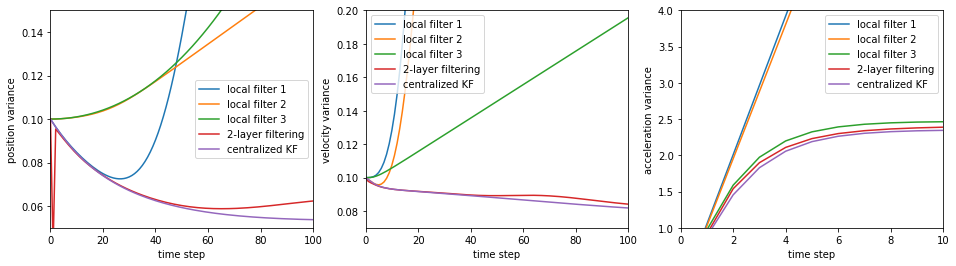

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

f, axes = plt.subplots(1, 3, figsize=(16, 4))

xlims = [(0, 100), (0, 100), (0, 10)]
ylims = [(0.05, 0.15), (0.07, 0.2), (1, 4)]
labels = ['position', 'velocity', 'acceleration']
for i in range(3):
    axes[i].set_ylim(ylims[i])
    axes[i].set_xlim(xlims[i])
    axes[i].set_xlabel('time step')
    axes[i].set_ylabel(f'{labels[i]} variance')
    #axes[i].plot(x_o_vars[i,:], label="Distibuted crude")
    axes[i].plot([p[0][i,i] for p in local_kf_variances], label='local filter 1')
    axes[i].plot([p[1][i,i] for p in local_kf_variances], label='local filter 2')
    axes[i].plot([p[2][i,i] for p in local_kf_variances], label='local filter 3')
    #axes[i].plot([p[i,i] for p in two_layers_psof_feedback_variances], label='Distributed PSOF')
    axes[i].plot([p[i,i] for p in two_layers_kf_variances], label='2-layer filtering')
    axes[i].plot([p[i,i] for p in centralized_kf_variances], label='centralized KF')
    axes[i].legend()

**My own plot**

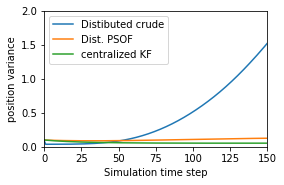

In [15]:
plt.figure(figsize=(4, 2.5))

xlims = (0, 150)
ylims = (0.0, 2.0)
plt.ylim(ylims)
plt.xlim(xlims)
plt.xlabel('Simulation time step')
plt.ylabel(f'position variance')
plt.plot(x_o_vars[0,:], label="Distibuted crude")
plt.plot([p[0,0] for p in two_layers_psof_feedback_variances], label='Dist. PSOF')
plt.plot([p[0,0] for p in centralized_kf_variances], label='centralized KF')
plt.legend()